<a href="https://colab.research.google.com/github/WilliamAshbee/computervision/blob/main/canny_edge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#https://towardsdatascience.com/canny-edge-detection-step-by-step-in-python-computer-vision-b49c3a2d8123

In [1]:
import numpy as np
five =np.array([[128,   254,   254,   255,   255],[0,   129,   255,   253,   254],
     [3,    0,   126,   255,   254],
     [0,     0,     0,   126,   255],
     [2,     2 ,    0 ,    0 ,  126]])

In [2]:
five

array([[128, 254, 254, 255, 255],
       [  0, 129, 255, 253, 254],
       [  3,   0, 126, 255, 254],
       [  0,   0,   0, 126, 255],
       [  2,   2,   0,   0, 126]])

In [3]:
sx = np.array([[1,     0,    -1],
     [2,     0,    -2],
     [1,     0,    -1]])

sx

array([[ 1,  0, -1],
       [ 2,  0, -2],
       [ 1,  0, -1]])

In [4]:
sy = np.array([[-1,    -2,    -1],
     [0,     0,     0],
     [1,     2,     1]])
sy

array([[-1, -2, -1],
       [ 0,  0,  0],
       [ 1,  2,  1]])

In [5]:
import numpy as np

def gaussian_kernel(size, sigma=1):
    size = int(size) // 2
    x, y = np.mgrid[-size:size+1, -size:size+1]
    normal = 1 / (2.0 * np.pi * sigma**2)
    g =  np.exp(-((x**2 + y**2) / (2.0*sigma**2))) * normal
    return g

In [6]:
gaussian_kernel(3,1)

array([[0.05854983, 0.09653235, 0.05854983],
       [0.09653235, 0.15915494, 0.09653235],
       [0.05854983, 0.09653235, 0.05854983]])

In [7]:
from scipy import ndimage

def sobel_filters(img):
    Kx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], np.float32)
    Ky = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], np.float32)
    
    Ix = ndimage.filters.convolve(img, Kx)
    Iy = ndimage.filters.convolve(img, Ky)
    
    G = np.hypot(Ix, Iy)
    G = G / G.max() * 255
    theta = np.arctan2(Iy, Ix)
    
    return (G, theta)


In [8]:
(img,D) = sobel_filters(five)

In [9]:
img


array([[169.55530234, 173.88372863,  42.05629828,   1.05547226,
          1.20342353],
       [173.56053036, 253.66514105, 169.22416661,  42.72381686,
          0.74633159],
       [ 42.06689248, 169.23305358, 254.66819886, 169.88907132,
         42.06027142],
       [  0.74633159,  40.72126317, 168.55366492, 255.        ,
        175.82564859],
       [  1.88808617,   2.0026178 ,  40.72536655, 174.36868059,
        170.22545809]])

In [10]:
D

array([[-2.35422599, -2.60443199, -2.36413083, -2.03444394, -1.76819189],
       [-2.11541356, -2.3548787 , -2.3502774 , -2.34838215, -1.89254688],
       [-2.33238946, -2.34436072, -2.35226266, -2.35815912, -2.37206617],
       [-0.32175055, -2.34799795, -2.35619449, -2.35619449, -2.11075542],
       [ 1.57079633,  0.78539816, -2.33980252, -2.5997804 , -2.35031221]])

In [11]:
def non_max_suppression(img, D):
    M, N = img.shape
    Z = np.zeros((M,N), dtype=np.int32)
    angle = D * 180. / np.pi
    angle[angle < 0] += 180

    
    for i in range(1,M-1):
        for j in range(1,N-1):
            try:
                q = 255
                r = 255
                
               #angle 0
                if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180):
                    q = img[i, j+1]
                    r = img[i, j-1]
                #angle 45
                elif (22.5 <= angle[i,j] < 67.5):
                    q = img[i+1, j-1]
                    r = img[i-1, j+1]
                #angle 90
                elif (67.5 <= angle[i,j] < 112.5):
                    q = img[i+1, j]
                    r = img[i-1, j]
                #angle 135
                elif (112.5 <= angle[i,j] < 157.5):
                    q = img[i-1, j-1]
                    r = img[i+1, j+1]

                if (img[i,j] >= q) and (img[i,j] >= r):
                    Z[i,j] = img[i,j]
                else:
                    Z[i,j] = 0

            except IndexError as e:
                pass
    
    return Z

In [12]:
img = non_max_suppression(img, D)

In [14]:
img

array([[  0,   0,   0,   0,   0],
       [  0, 253,   0,   0,   0],
       [  0, 169, 254, 169,   0],
       [  0,   0,   0, 255,   0],
       [  0,   0,   0,   0,   0]], dtype=int32)

In [13]:
def threshold(img, lowThresholdRatio=0.05, highThresholdRatio=0.09):
    
    highThreshold = img.max() * highThresholdRatio;
    lowThreshold = highThreshold * lowThresholdRatio;
    
    M, N = img.shape
    res = np.zeros((M,N), dtype=np.int32)
    
    weak = np.int32(25)
    strong = np.int32(255)
    
    strong_i, strong_j = np.where(img >= highThreshold)
    zeros_i, zeros_j = np.where(img < lowThreshold)
    
    weak_i, weak_j = np.where((img <= highThreshold) & (img >= lowThreshold))
    
    res[strong_i, strong_j] = strong
    res[weak_i, weak_j] = weak
    
    return (res, weak, strong)


In [15]:
post_threshold = threshold(img,lowThresholdRatio=.1,highThresholdRatio=.9)

In [16]:
post_threshold

(array([[  0,   0,   0,   0,   0],
        [  0, 255,   0,   0,   0],
        [  0,  25, 255,  25,   0],
        [  0,   0,   0, 255,   0],
        [  0,   0,   0,   0,   0]], dtype=int32), 25, 255)

In [17]:
def hysteresis(img, weak, strong=255):
    M, N = img.shape  
    for i in range(1, M-1):
        for j in range(1, N-1):
            if (img[i,j] == weak):
                try:
                    if ((img[i+1, j-1] == strong) or (img[i+1, j] == strong) or (img[i+1, j+1] == strong)
                        or (img[i, j-1] == strong) or (img[i, j+1] == strong)
                        or (img[i-1, j-1] == strong) or (img[i-1, j] == strong) or (img[i-1, j+1] == strong)):
                        img[i, j] = strong
                    else:
                        img[i, j] = 0
                except IndexError as e:
                    pass
    return img


In [20]:
final_img = hysteresis(post_threshold[0],post_threshold[1],post_threshold[2])

In [22]:
import matplotlib.pyplot as plt

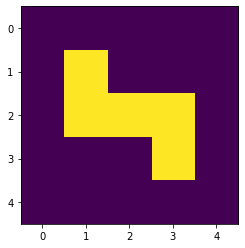

In [23]:
plt.imshow(final_img)